In [2]:
import pandas as pd
import io
from google.colab import files
myfile=files.upload()


Saving 가격데이터_14.xlsx to 가격데이터_14.xlsx
Saving 재무비율데이터_14.xlsx to 재무비율데이터_14.xlsx
Saving 재무제표데이터_14.xlsx to 재무제표데이터_14.xlsx
Saving 투자지표데이터_14.xlsx to 투자지표데이터_14.xlsx


In [3]:
myfiles=files.upload()

Saving 가격데이터.xlsx to 가격데이터.xlsx
Saving 재무비율데이터.xlsx to 재무비율데이터.xlsx
Saving 투자지표데이터.xlsx to 투자지표데이터.xlsx
Saving 재무제표데이터.xlsx to 재무제표데이터.xlsx


In [100]:
invest_df['2018/12']

,PBR,PCR,PER,PSR,총현금흐름
Unnamed: 0,,,,,
A005090,0.50,8.00,NaN,0.53,173
A006110,0.44,4.60,16.71,0.27,116
A001060,3.37,35.49,113.38,1.70,347
A017810,0.98,3.47,15.02,0.14,907
A007660,1.46,14.73,NaN,0.48,4996
...,...,...,...,...,...
A019490,0.46,9.31,27.92,0.49,5
A071950,1.80,15.54,NaN,0.38,63
A030790,1.94,NaN,NaN,2.32,-183


In [94]:
import numpy as np

def check_IFRS(x):
    if x == 'N/A(IFRS)':
        return np.NaN
    else:
        return x

In [91]:
def low_per(invest_df, index_date, num):
    invest_df[(index_date, 'PER')] = pd.to_numeric(invest_df[(index_date, 'PER')])
    per_sorted = invest_df.sort_values(by=(index_date, 'PER'))
    return per_sorted[index_date][:num]

In [92]:
def high_roa(fr_df, index_date, num):
    fr_df[(index_date, 'ROA')] = fr_df[(index_date, 'ROA')].apply(check_IFRS)
    fr_df[(index_date, 'ROA')] = pd.to_numeric(fr_df[(index_date, 'ROA')] )
    sorted_roa = fr_df.sort_values(by=(index_date, 'ROA'), ascending=False)
    return sorted_roa[index_date][:num]

In [4]:
#  [코드 4.6] 재무 데이터 전처리하는 함수 (CH4. 전략 구현하기.ipynb)

def get_finance_data(path):
    data_path = path
    raw_data = pd.read_excel(data_path)
    raw_data=raw_data.set_index('Unnamed: 0')
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])
    
    new_big_col = []
    for num, col in enumerate(big_col):
        if 'Unnamed' in col:
            new_big_col.append(new_big_col[num-1])
        else:
            new_big_col.append(big_col[num])
            
    raw_data.columns = [new_big_col, small_col]
    clean_df = raw_data.loc[ raw_data.index.dropna() ]
    
    return clean_df

In [5]:
#  [코드 4.22] 마법공식 함수로 만들기 (CH4. 전략 구현하기.ipynb)

def magic_formula(fr_df, invest_df, index_date, num):
    per = low_per(invest_df, index_date, None)
    roa = high_roa(fr_df, index_date, None)
    per['per순위'] = per['PER'].rank()
    roa['roa순위'] = roa['ROA'].rank(ascending=False)
    magic = pd.merge(per, roa, how='outer', left_index=True, right_index=True)
    magic['마법공식 순위'] = (magic['per순위'] + magic['roa순위']).rank().sort_values()
    magic = magic.sort_values(by='마법공식 순위')
    return magic[:num]

In [6]:
#  [코드 4.23] 저평가 지수를 기준으로 정렬하여 순위 만들어 주는 함수 (CH4. 전략 구현하기.ipynb)

def get_value_rank(invest_df, value_type, index_date, num):
    invest_df[(index_date,  value_type)] = pd.to_numeric(invest_df[(index_date,  value_type)])
    value_sorted = invest_df.sort_values(by=(index_date,  value_type))[index_date]
    value_sorted[  value_type + '순위'] = value_sorted[value_type].rank()
    return value_sorted[[value_type, value_type + '순위']][:num]

In [7]:
#  [코드 4.29] F-score 함수(CH4. 전략 구현하기.ipynb)

def get_fscore(fs_df, index_date, num):
    fscore_df = fs_df[index_date]
    fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
    fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
    fscore_df['더큰영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > fscore_df['당기순이익']
    fscore_df['종합점수'] = fscore_df[['당기순이익점수', '영업활동점수', '더큰영업활동점수']].sum(axis=1)
    fscore_df = fscore_df[fscore_df['종합점수'] == 3]
    return fscore_df[:num]

In [8]:
#  [코드 4.25] 저평가 지표 조합 함수 (CH4. 전략 구현하기.ipynb)

def make_value_combo(value_list, invest_df, index_date, num):
    
    for i, value in enumerate(value_list):
        temp_df = get_value_rank(invest_df, value, index_date, None)
        if i == 0:
            value_combo_df = temp_df
            rank_combo = temp_df[value + '순위']
        else:
            value_combo_df = pd.merge(value_combo_df, temp_df, how='outer', left_index=True, right_index=True)
            rank_combo = rank_combo + temp_df[value + '순위']
    
    value_combo_df['종합순위'] = rank_combo.rank()
    value_combo_df = value_combo_df.sort_values(by='종합순위')
    
    return value_combo_df[:num]

In [9]:
#  [코드 4.39] 저평가 + Fscore 함수화 (CH4. 전략 구현하기.ipynb)

def get_value_quality(invest_df, fs_df, index_date, num):
    value = make_value_combo(['PER', 'PBR', 'PSR', 'PCR'], invest_df, index_date, None)
    quality = get_fscore(fs_df, index_date, None)
    value_quality = pd.merge(value, quality, how='outer', left_index=True, right_index=True)
    value_quality_filtered = value_quality[value_quality['종합점수'] == 3]
    vq_df = value_quality_filtered.sort_values(by='종합순위')
    return vq_df[:num]
    
def get_finance_data(path):
    data_path = path
    raw_data = pd.read_excel(data_path)
    raw_data=raw_data.set_index('Unnamed: 0')
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])
    
    new_big_col = []
    for num, col in enumerate(big_col):
        if 'Unnamed' in col:
            new_big_col.append(new_big_col[num-1])
        else:
            new_big_col.append(big_col[num])
            
    raw_data.columns = [new_big_col, small_col]
    clean_df = raw_data.loc[ raw_data.index.dropna() ]
    
    return clean_df

In [10]:
def high_roa(fr_df, index_date, num):
    fr_df[(index_date, 'ROA')] = fr_df[(index_date, 'ROA')].apply(check_IFRS)
    fr_df[(index_date, 'ROA')] = pd.to_numeric(fr_df[(index_date, 'ROA')] )
    sorted_roa = fr_df.sort_values(by=(index_date, 'ROA'), ascending=False)
    return sorted_roa[index_date][:num]

In [14]:
#  [코드 5.1] 필요한 모듈과 데이터를 가져오기 (Ch5. 백테스트.ipynb)

#import python_quant
import pandas as pd

#data_fs=pd.read_excel(io.BytesIO(myfile['재무제표데이터.xlsx']))
#data_fr=pd.read_excel(io.BytesIO(myfile['재무비율데이터.xlsx']))
#data_invest=pd.read_excel(io.BytesIO(myfile['투자지표데이터.xlsx']))
fs_path_14=io.BytesIO(myfile['재무제표데이터_14.xlsx'])
fr_path_14=io.BytesIO(myfile['재무비율데이터_14.xlsx'])
invest_path_14=io.BytesIO(myfile['투자지표데이터_14.xlsx'])
price_path_14=io.BytesIO(myfile['가격데이터_14.xlsx'])

fs_path=io.BytesIO(myfiles['재무제표데이터.xlsx'])
fr_path=io.BytesIO(myfiles['재무비율데이터.xlsx'])
invest_path=io.BytesIO(myfiles['투자지표데이터.xlsx'])
price_path=io.BytesIO(myfiles['가격데이터.xlsx'])

#raw_data = pd.read_excel(fs_path)



#fs_path = r'C:\Users\JK\Desktop\주식 책쓰기\주식 책 데이터\재무제표데이터.xlsx'
fs_df = get_finance_data(fs_path)
#fr_path = r'C:\Users\JK\Desktop\주식 책쓰기\주식 책 데이터\재무비율데이터.xlsx'
fr_df = get_finance_data(fr_path)
#invest_path = r'C:\Users\JK\Desktop\주식 책쓰기\주식 책 데이터\투자지표데이터.xlsx'
invest_df = get_finance_data(invest_path)
#price_path = r'C:\Users\JK\Desktop\주식 책쓰기\주식 책 데이터\가격데이터.xlsx'
price_df = pd.read_excel(price_path)


#fs_path = r'C:\Users\JK\Desktop\주식 책쓰기\주식 책 데이터\재무제표데이터.xlsx'
fs_df_14 = get_finance_data(fs_path_14)
#fr_path = r'C:\Users\JK\Desktop\주식 책쓰기\주식 책 데이터\재무비율데이터.xlsx'
fr_df_14 = get_finance_data(fr_path_14)
#invest_path = r'C:\Users\JK\Desktop\주식 책쓰기\주식 책 데이터\투자지표데이터.xlsx'
invest_df_14 = get_finance_data(invest_path_14)
#price_path = r'C:\Users\JK\Desktop\주식 책쓰기\주식 책 데이터\가격데이터.xlsx'
price_df_14 = pd.read_excel(price_path_14)

In [18]:
price_df=price_df.set_index('Unnamed: 0')
price_df_14=price_df_14.set_index('Unnamed: 0')

In [22]:
price_df.columns

Index(['095570', '006840', '027410', '282330', '138930', '001460', '001465',
       '001040', '079160', '00104K',
       ...
       '298000', '093370', '081660', '005870', '079980', '005010', '000540',
       '000547', '000545', '003280'],
      dtype='object', length=943)

In [23]:
price_df_14.columns

Index(['060310', '095570', '068400', '006840', '054620', '265520', '211270',
       '027410', '282330', '138930',
       ...
       '084110', '145020', '069260', '024060', '010240', '189980', '000540',
       '003280', '037440', '238490'],
      dtype='object', length=2266)

In [24]:
#  [코드 5.2] 2015/12 기준으로 저PBR 종목 20개 가져오기 (Ch5. 백테스트.ipynb)

low_pbr_st = get_value_rank(invest_df, 'PBR', '2018/12', 20)

In [25]:
#  [코드 5.3] 종목 코드만 가져오기 (Ch5. 백테스트.ipynb)

low_pbr_st.index

Index(['A012170', 'A007860', 'A200880', 'A000950', 'A010100', 'A058650',
       'A005010', 'A012320', 'A003480', 'A001620', 'A000500', 'A002220',
       'A009200', 'A002820', 'A003830', 'A000180', 'A006370', 'A010690',
       'A001530', 'A000140'],
      dtype='object', name='Unnamed: 0')

In [26]:
price_df=price_df.set_index('Unnamed: 0')


KeyError: ignored

In [27]:
price_df

,095570,006840,027410,282330,138930,001460,001465,001040,079160,00104K,...,298000,093370,081660,005870,079980,005010,000540,000547,000545,003280
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-12-21,6110,56900,41729,NaN,8940,396500,175000,174920,59504,NaN,...,NaN,7310,13880,13150,7670,2712,3645,16750,3635,14238
2016-12-22,6110,56900,41368,NaN,8930,398500,174000,173034,59414,NaN,...,NaN,7620,13600,12600,7710,2740,3625,16350,3625,14678
2016-12-23,6270,55700,42862,NaN,8930,397000,174500,173977,59504,NaN,...,NaN,7510,13800,12750,7990,2785,3690,16350,3645,14568
2016-12-26,6400,54500,42656,NaN,8910,398000,174000,174449,60321,NaN,...,NaN,7380,13740,12900,8110,2831,3690,17350,3640,14128
2016-12-27,6500,54600,41832,NaN,8900,397000,174000,173506,60956,NaN,...,NaN,7310,13960,12850,8100,2822,3685,17250,3670,14128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19,6060,17100,4160,192500.0,7080,370000,141000,87400,18650,75900.0,...,118000.0,11950,35200,6230,4990,5630,3470,20700,6460,1415
2023-01-20,6050,17400,4200,192500.0,7160,370000,140000,85300,18600,75500.0,...,122000.0,12100,36200,6330,5030,5630,3545,19400,6440,1425
2023-01-25,6070,17270,4190,189900.0,7240,369500,140500,84200,18230,74300.0,...,117200.0,12310,36500,6420,5030,5530,3525,19100,6460,1416


In [28]:
#  [코드 5.4] 저pbr 주식들의 2016년 1월 이후의 가격 데이터 가져오기 (Ch5. 백테스트.ipynb)

code_list = []
for code in low_pbr_st.index:
    code_list.append(code.replace('A',''))
    
pbr_price = price_df[code_list]['2016-12':]

In [29]:
pbr_price

,012170,007860,200880,000950,010100,058650,005010,012320,003480,001620,000500,002220,009200,002820,003830,000180,006370,010690,001530,000140
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
2016-12-21,23401,10550,14350,26900,2800,127000,2712,76853,4680,2236,19509,2475,2670,10600,105500,3235,13550,6190,5318,12300
2016-12-22,23090,10400,14200,26600,2800,127500,2740,76853,4735,2498,19552,2455,2660,10600,105000,3185,13550,6310,5318,12400
2016-12-23,22468,10550,14450,26700,2760,128500,2785,77273,4765,2438,19552,2480,2635,10600,105000,3195,13450,6310,5327,12400
2016-12-26,22158,10750,14200,26850,2750,127000,2831,77273,4760,2464,19552,2460,2625,10700,104000,3170,13600,6570,5327,12600
2016-12-27,21744,10750,14350,26600,2770,127500,2822,79999,4740,2413,19552,2485,2645,10800,104000,3145,13700,6520,5344,12600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19,785,7320,8580,43350,2705,103000,5630,92000,3730,606,18550,3020,2455,3420,120500,2090,9950,8590,15450,9980
2023-01-20,798,7230,8550,42850,2690,103500,5630,92000,3730,607,18550,3070,2475,3410,121000,2135,9960,8480,15750,10100
2023-01-25,798,7310,8560,43100,2710,103500,5530,88000,3840,608,18490,3080,2515,3410,129400,2155,9980,8510,15750,10120


In [30]:
#  [코드 5.5] 각 종목마다 몇 개씩 살지 계산하여 포트폴리오 구성 (Ch5. 백테스트.ipynb)

pf_stock_num = {}
stock_amount = 0

for code in pbr_price.columns:
    temp = int( 5000000 / pbr_price[code][0] )
    pf_stock_num[code] = temp
    stock_amount = stock_amount + temp * pbr_price[code][0]
    
cash_amount = 100000000 - stock_amount

In [31]:
#  [코드 5.6] 주식 포트폴리오의 변화 구하기 (Ch5. 백테스트.ipynb)

stock_pf = 0
for code in pbr_price.columns:
    stock_pf = stock_pf + pbr_price[code] * pf_stock_num[code]

In [32]:
#  [코드 5.7] 주식 포트폴리오 데이터프레임으로 만들어주기 (Ch5. 백테스트.ipynb)

low_pbr_backtest = pd.DataFrame({'주식포트폴리오':stock_pf[:'2016-12']})

In [33]:
#  [코드 5.8] 현금 포트폴리오 데이터프레임에 추가하기 (Ch5. 백테스트.ipynb)

low_pbr_backtest['현금포트폴리오'] = [cash_amount] * len(low_pbr_backtest)

In [34]:
#  [코드 5.9] 종합 포트폴리오와 일 변화율 데이터프레임에 추가하기 (Ch5. 백테스트.ipynb)

low_pbr_backtest['종합포트폴리오'] =  low_pbr_backtest['주식포트폴리오'] + low_pbr_backtest['현금포트폴리오']
low_pbr_backtest['일변화율'] = low_pbr_backtest['종합포트폴리오'].pct_change()

In [35]:
#  [코드 5.10] 초기 투자금 대비 변화율 데이터프레임에 추가하기 (Ch5. 백테스트.ipynb)

low_pbr_backtest['총변화율'] = low_pbr_backtest['종합포트폴리오']/100000000 - 1

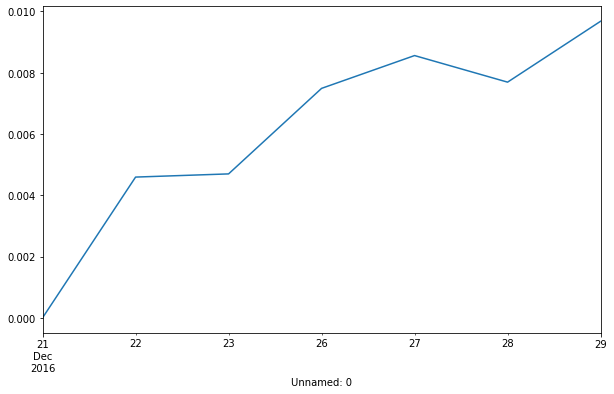

In [36]:
#  [코드 5.11] 초기 투자금 대비 변화율 그래프 그리기 (Ch5. 백테스트.ipynb)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
low_pbr_backtest['총변화율'].plot()
plt.show()

In [37]:
#  [코드 5.12] 백테스트 함수 버젼1 (Ch5. 백테스트.ipynb)


def backtest_beta(price_df, strategy_df, start_date, end_date, initial_money):

    code_list = []
    for code in strategy_df.index:
        code_list.append(code.replace('A',''))

    strategy_price = price_df[code_list][start_date:end_date]

    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(strategy_df)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
    backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
    backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
    backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
    backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
    return backtest_df

In [38]:
#  [코드 5.13] 저per 백테스트 (Ch5. 백테스트.ipynb)

strategy_date = '2018/12'
start_date = '2019-6'
end_date = '2020-5'
initial_money = 100000000

low_per = get_value_rank(invest_df, 'PER', strategy_date, 20)
per_backtest = backtest_beta(price_df, low_per, start_date, end_date, initial_money)

In [44]:
per_backtest

,주식포트폴리오,현금포트폴리오,종합포트폴리오,일변화율,총변화율
Unnamed: 0,,,,,
2019-06-03,99764030.0,235970.0,100000000.0,NaN,0.000000
2019-06-04,101194817.0,235970.0,101430787.0,0.014308,0.014308
2019-06-05,102008603.0,235970.0,102244573.0,0.008023,0.022446
2019-06-07,101836801.0,235970.0,102072771.0,-0.001680,0.020728
2019-06-10,102730874.0,235970.0,102966844.0,0.008759,0.029668
...,...,...,...,...,...
2020-05-25,88986730.0,235970.0,89222700.0,0.001153,-0.107773
2020-05-26,89237565.0,235970.0,89473535.0,0.002811,-0.105265
2020-05-27,89649468.0,235970.0,89885438.0,0.004604,-0.101146


In [39]:
#  [코드 5.14] 특정 날짜에 가격 데이터프레임에 데이터가 존재하는 종목들 리스트 가져오기 (Ch5. 백테스트.ipynb)

price_df[start_date].iloc[0].dropna().index

<ipython-input-39-88a97bdf4e31>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df[start_date].iloc[0].dropna().index


Index(['095570', '006840', '027410', '282330', '138930', '001460', '001465',
       '001040', '079160', '000120',
       ...
       '298000', '093370', '081660', '005870', '079980', '005010', '000540',
       '000547', '000545', '003280'],
      dtype='object', length=876)

In [40]:
#  [코드 5.15] 종목 코드 앞에 'A'붙이기 (Ch5. 백테스트.ipynb)

new_code_list = []
for code in price_df[start_date].iloc[0].dropna().index:
    new_code_list.append('A' + code)

<ipython-input-40-86da58ccde92>:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  for code in price_df[start_date].iloc[0].dropna().index:


In [41]:
#  [코드 5.16] 해당 날짜에 가격이 없으면 투자 관련 데이터에서 해당 종목 없애는 함수 (Ch5. 백테스트.ipynb)

def select_code_by_price(price_df, data_df, start_date):
    new_code_list = []
    for code in price_df[start_date].iloc[0].dropna().index:
        new_code_list.append('A' + code)
        
    selected_df =  data_df.loc[new_code_list]
    return selected_df

In [59]:
#  [코드 5.13] 저per 백테스트 (Ch5. 백테스트.ipynb)

strategy_date = '2018/12'
start_date = '2019-6'
end_date = '2020-5'
initial_money = 100000000

low_per = get_value_rank(invest_df, 'PER', strategy_date, 20)
per_backtest = backtest_beta(price_df, low_per, start_date, end_date, initial_money)

In [87]:
#  [코드 5.13] 저pbr 백테스트 (Ch5. 백테스트.ipynb)

strategy_date = '2018/12'
start_date = '2019-6'
end_date = '2020-5'
initial_money = 100000000

low_pbr = get_value_rank(invest_df, 'PBR', strategy_date, 20)
pbr_backtest = backtest_beta(price_df, low_pbr, start_date, end_date, initial_money)

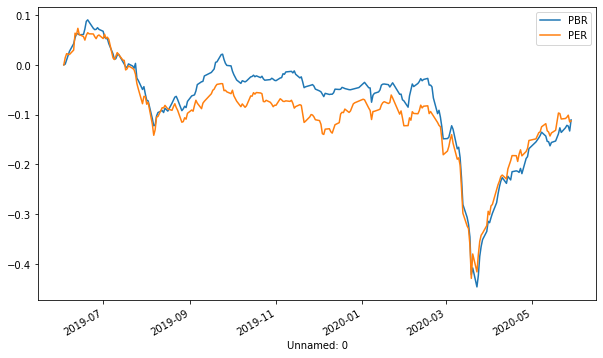

In [61]:
plt.figure(figsize=(10, 6))
pbr_backtest['총변화율'].plot(label='PBR')
per_backtest['총변화율'].plot(label='PER')
plt.legend()
plt.show()

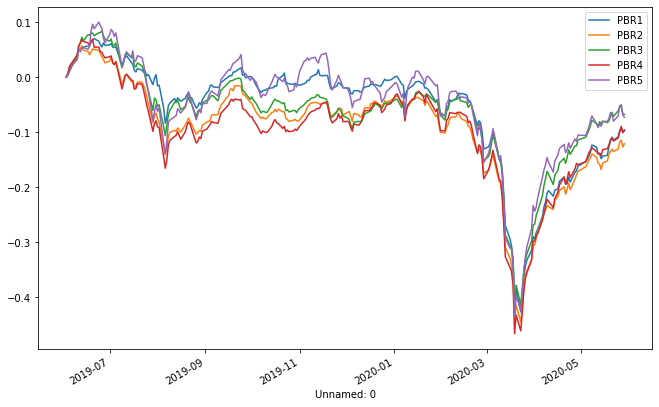

In [63]:
#  [코드 5.20] pbr 구간별 수익률 비교 (Ch5. 백테스트.ipynb)

strategy_date = '2018/12'
start_date = '2019-6'
end_date = '2020-5'
initial_money = 100000000
all_pbr = get_value_rank(invest_df, 'PBR', strategy_date, None).dropna()
#pbr_backtest = backtest_beta(price_df, low_pbr, start_date, end_date, initial_money)
#all_pbr = get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PBR', strategy_date, None).dropna()

length = int(len(all_pbr)/5)

pbr_backtest1 = backtest_beta(price_df, all_pbr[:length], start_date, end_date, initial_money)
pbr_backtest2 = backtest_beta(price_df, all_pbr[length:length*2], start_date, end_date, initial_money)
pbr_backtest3 = backtest_beta(price_df, all_pbr[length*2:length*3], start_date, end_date, initial_money)
pbr_backtest4 = backtest_beta(price_df, all_pbr[length*3:length*4], start_date, end_date, initial_money)
pbr_backtest5 = backtest_beta(price_df, all_pbr[length*4:], start_date, end_date, initial_money)

plt.figure(figsize=(11, 7))
pbr_backtest1['총변화율'].plot(label='PBR1')
pbr_backtest2['총변화율'].plot(label='PBR2')
pbr_backtest3['총변화율'].plot(label='PBR3')
pbr_backtest4['총변화율'].plot(label='PBR4')
pbr_backtest5['총변화율'].plot(label='PBR5')
plt.legend()
plt.show()

<ipython-input-7-fab60ce7932b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
<ipython-input-7-fab60ce7932b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
<ipython-input-7-fab60ce7932b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

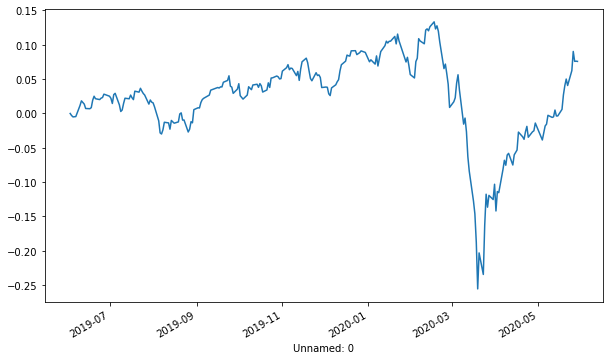

In [66]:
# [코드 5.22] fscroe 백테스트 (Ch5. 백테스트.ipynb)

strategy_date = '2019/12'
start_date = '2019-6'
end_date = '2020-5'
initial_money = 100000000

f_score_result = get_fscore(fs_df, strategy_date, 20)

#f_score_result = get_fscore(select_code_by_price(price_df, fs_df, start_date), strategy_date, 20)
f_score_backtest = backtest_beta(price_df, f_score_result, start_date, end_date, initial_money)

plt.figure(figsize=(10, 6))
f_score_backtest['총변화율'].plot()
plt.show()

In [67]:
#  [코드 5.17] 저per 포트폴리오 백테스트 (Ch5. 백테스트.ipynb)

# strategy_date = '2018/12'
# start_date = '2019-6'
# end_date = '2020-5'
# initial_money = 100000000

# low_per = get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PER', strategy_date, 20)
# per_backtest = backtest_beta(price_df, low_per, start_date, end_date, initial_money)

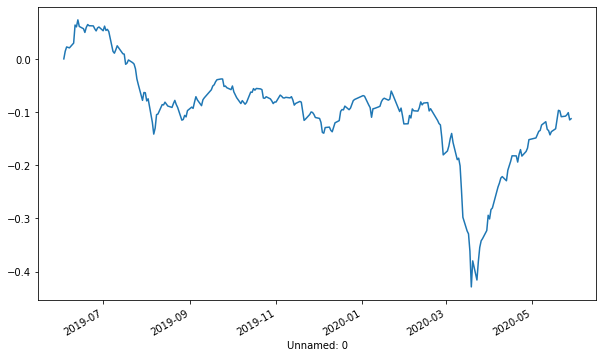

In [48]:
#  [코드 5.18] 저per 백테스트 결과 그래프 그리기 (Ch5. 백테스트.ipynb)

plt.figure(figsize=(10, 6))
per_backtest['총변화율'].plot()
plt.show()

In [86]:
#  [코드 5.19] 저pbr, 저per 전략 비교하기 (Ch5. 백테스트.ipynb)

strategy_date = '2018/12'
start_date = '2019-6'
end_date = '2020-5'
initial_money = 100000000

low_pbr = get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PBR', strategy_date, 20)
low_per = get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PER', strategy_date, 20)

pbr_backtest = backtest_beta(price_df, low_pbr, start_date, end_date, initial_money)
per_backtest = backtest_beta(price_df, low_per, start_date, end_date, initial_money)

plt.figure(figsize=(10, 6))
pbr_backtest['총변화율'].plot(label='PBR')
per_backtest['총변화율'].plot(label='PER')
plt.legend()
plt.show()

<ipython-input-41-4ebdb13ad957>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  for code in price_df[start_date].iloc[0].dropna().index:


KeyError: ignored

c:\users\jk\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


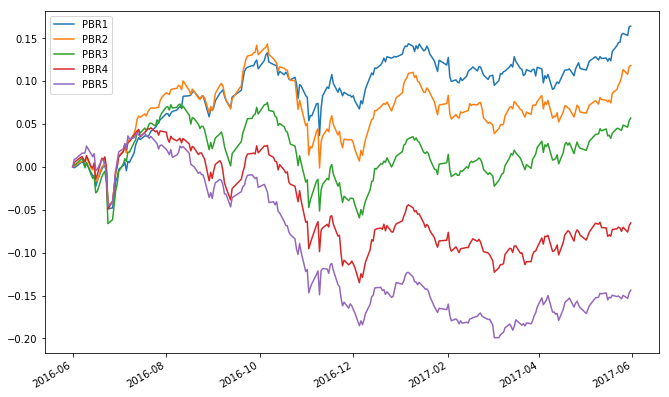

In [ ]:
#  [코드 5.20] pbr 구간별 수익률 비교 (Ch5. 백테스트.ipynb)

strategy_date = '2015/12'
start_date = '2016-6'
end_date = '2017-5'
initial_money = 100000000

all_pbr = python_quant.get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PBR', strategy_date, None).dropna()

length = int(len(all_pbr)/5)

pbr_backtest1 = backtest_beta(price_df, all_pbr[:length], start_date, end_date, initial_money)
pbr_backtest2 = backtest_beta(price_df, all_pbr[length:length*2], start_date, end_date, initial_money)
pbr_backtest3 = backtest_beta(price_df, all_pbr[length*2:length*3], start_date, end_date, initial_money)
pbr_backtest4 = backtest_beta(price_df, all_pbr[length*3:length*4], start_date, end_date, initial_money)
pbr_backtest5 = backtest_beta(price_df, all_pbr[length*4:], start_date, end_date, initial_money)

plt.figure(figsize=(11, 7))
pbr_backtest1['총변화율'].plot(label='PBR1')
pbr_backtest2['총변화율'].plot(label='PBR2')
pbr_backtest3['총변화율'].plot(label='PBR3')
pbr_backtest4['총변화율'].plot(label='PBR4')
pbr_backtest5['총변화율'].plot(label='PBR5')
plt.legend()
plt.show()

c:\users\jk\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


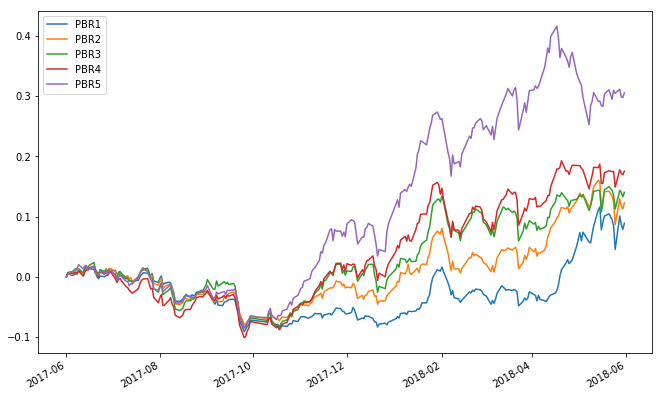

In [ ]:
#  [코드 5.21] 연도를 바꾼 뒤 pbr 구간별 수익률 비교 (Ch5. 백테스트.ipynb)

strategy_date = '2016/12'
start_date = '2017-6'
end_date = '2018-5'
initial_money = 100000000

all_pbr = python_quant.get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PBR', strategy_date, None).dropna()

length = int(len(all_pbr)/5)

pbr_backtest1 = backtest_beta(price_df, all_pbr[:length], start_date, end_date, initial_money)
pbr_backtest2 = backtest_beta(price_df, all_pbr[length:length*2], start_date, end_date, initial_money)
pbr_backtest3 = backtest_beta(price_df, all_pbr[length*2:length*3], start_date, end_date, initial_money)
pbr_backtest4 = backtest_beta(price_df, all_pbr[length*3:length*4], start_date, end_date, initial_money)
pbr_backtest5 = backtest_beta(price_df, all_pbr[length*4:], start_date, end_date, initial_money)

plt.figure(figsize=(11, 7))
pbr_backtest1['총변화율'].plot(label='PBR1')
pbr_backtest2['총변화율'].plot(label='PBR2')
pbr_backtest3['총변화율'].plot(label='PBR3')
pbr_backtest4['총변화율'].plot(label='PBR4')
pbr_backtest5['총변화율'].plot(label='PBR5')
plt.legend()
plt.show()

c:\users\jk\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
c:\users\jk\anaconda3\python_quant.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
c:\users\jk\anaconda3\python_quant.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

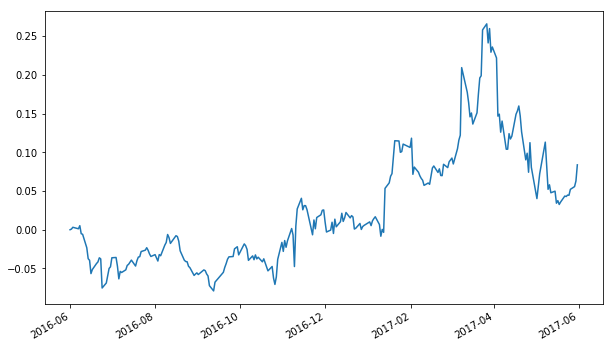

In [ ]:
# [코드 5.22] fscroe 백테스트 (Ch5. 백테스트.ipynb)

strategy_date = '2015/12'
start_date = '2016-6'
end_date = '2017-5'
initial_money = 100000000

f_score_result = python_quant.get_fscore(select_code_by_price(price_df, fs_df, start_date), strategy_date, 20)
f_score_backtest = backtest_beta(price_df, f_score_result, start_date, end_date, initial_money)

plt.figure(figsize=(10, 6))
f_score_backtest['총변화율'].plot()
plt.show()

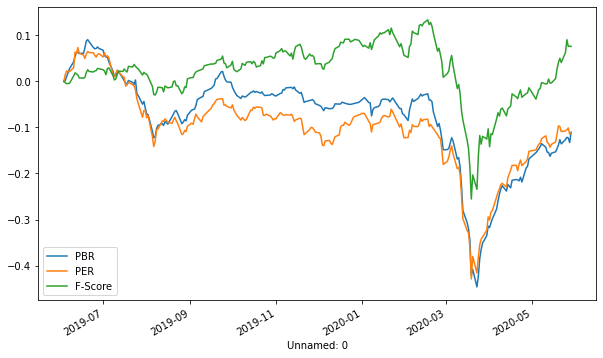

In [68]:
# [코드 5.23] fscroe, 저PER, 저PBR 전략 비교 그래프 그리기 (Ch5. 백테스트.ipynb)

plt.figure(figsize=(10, 6))
pbr_backtest['총변화율'].plot(label='PBR')
per_backtest['총변화율'].plot(label='PER')
f_score_backtest['총변화율'].plot(label='F-Score')
plt.legend()
plt.show()

In [69]:
# [코드 5.24] 백테스트 시작날짜가 주어지면 전략 기준 날짜를 계산하는 함수 (Ch5. 백테스트.ipynb)

def get_strategy_date(start_date):
    temp_year = int(start_date.split('-')[0])
    temp_month = start_date.split('-')[1]
    if temp_month in '1 2 3 4 5'.split(' '):
        strategy_date = str(temp_year - 2) + '/12'
    else:
        strategy_date = str(temp_year - 1) + '/12'
    return strategy_date

In [ ]:
# [코드 5.25] 백테스트 기간이 주어지면 리밸런싱 주기로 나누기 (Ch5. 백테스트.ipynb)

start_date = '2015-6'
end_date = '2018-5'

start_year = int(start_date.split('-')[0])
end_year = int(end_date.split('-')[0])

for temp in range(start_year, end_year):
    print(str(temp) + '-6', str(temp+1) + '-6')

2015-6 2016-6
2016-6 2017-6
2017-6 2018-6


In [72]:
# [코드 5.26] 2기간 동안 리밸런싱 한 번 하면서 백테스트 하기 (Ch5. 백테스트.ipynb)

start_date1 = '2019-6'
end_date1 = '2020-5'
strategy_date1 = get_strategy_date(start_date1)
initial_money1 = 100000000
low_per1 = get_value_rank(invest_df, 'PER', strategy_date1, 20)
#low_per1 = python_quant.get_value_rank(select_code_by_price(price_df, invest_df, start_date1), 'PER', strategy_date1, 20)
per_backtest1 = backtest_beta(price_df, low_per1, start_date1, end_date1, initial_money1)

start_date2 = '2020-6'
end_date2 = '2021-5'
strategy_date2 = get_strategy_date(start_date2)
initial_money2 = 100000000

low_per2= get_value_rank(invest_df, 'PER', strategy_date2, 20)

#low_per2 = python_quant.get_value_rank(select_code_by_price(price_df, invest_df, start_date2), 'PER', strategy_date2, 20)
per_backtest2 = backtest_beta(price_df, low_per2, start_date2, end_date2, initial_money2)

In [73]:
# [코드 5.27] 2기간 동안 리밸런싱 한 번 하면서 백테스트 하기 개선 (Ch5. 백테스트.ipynb)

start_date1 = '2019-6'
end_date1 = '2020-6'
strategy_date1 = get_strategy_date(start_date1)
initial_money1 = 100000000
low_per1 = get_value_rank(invest_df, 'PER', strategy_date1, 20)

#low_per1 = get_value_rank(select_code_by_price(price_df, invest_df, start_date1), 'PER', strategy_date1, 20)
per_backtest1 = backtest_beta(price_df, low_per1, start_date1, end_date1, initial_money1)
temp_end1 = per_backtest1[end_date1].index[0]
per_backtest1 = per_backtest1[:temp_end1]

start_date2 = '2020-6'
end_date2 = '2021-6'
strategy_date2 = get_strategy_date(start_date2)
initial_money2 = per_backtest1['종합포트폴리오'][-1]
low_per2= get_value_rank(invest_df, 'PER', strategy_date2, 20)

#low_per2 = get_value_rank(select_code_by_price(price_df, invest_df, start_date2), 'PER', strategy_date2, 20)
per_backtest2 = backtest_beta(price_df, low_per2, start_date2, end_date2, initial_money2)
temp_end2 = per_backtest2[end_date2 ].index[0]
per_backtest2 = per_backtest2[:temp_end2]

<ipython-input-73-3e5758eb123d>:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end1 = per_backtest1[end_date1].index[0]
<ipython-input-73-3e5758eb123d>:22: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end2 = per_backtest2[end_date2 ].index[0]


In [74]:
# [코드 5.28] 두 번의 백테스트 기간 동안 생성된 2개의 데이터프레임을 붙이기 (Ch5. 백테스트.ipynb)

total_backtest = pd.concat([per_backtest1[:-1], per_backtest2])

In [75]:
# [코드 5.29] 이어 붙인 데이터프레임에서 변화율들을 다시 계산하여 저장 (Ch5. 백테스트.ipynb)

total_backtest['일변화율'] = total_backtest['종합포트폴리오'].pct_change()
total_backtest['총변화율'] = total_backtest['종합포트폴리오']/ total_backtest['종합포트폴리오'][0] - 1

In [79]:
# [코드 5.30] 리밸런싱 코드 for문으로 정리 (Ch5. 백테스트.ipynb)

start_date = '2019-6'
end_date = '2022-5'
initial_money = 100000000

start_year = int(start_date.split('-')[0])
end_year = int(end_date.split('-')[0])

total_df = 0
for temp in range(start_year, end_year):
    this_term_start = str(temp) + '-6'
    this_term_end = str(temp+1) + '-6'
    strategy_date = get_strategy_date(this_term_start)
    low_per = get_value_rank(invest_df, 'PER', strategy_date, 20)

    #low_per = python_quant.get_value_rank(select_code_by_price(price_df, invest_df, this_term_start), 'PER', strategy_date, 20)
    per_backtest = backtest_beta(price_df, low_per, this_term_start, this_term_end, initial_money)
    temp_end = per_backtest[this_term_end].index[0]
    per_backtest = per_backtest[:temp_end]
    initial_money =  per_backtest['종합포트폴리오'][-1]
    if temp == start_year:
        total_df = per_backtest
    else:
        total_df = pd.concat([total_df[:-1], per_backtest])
        
total_df ['일변화율'] = total_df ['종합포트폴리오'].pct_change()
total_df ['총변화율'] = total_df ['종합포트폴리오']/ total_df ['종합포트폴리오'][0] - 1

<ipython-input-79-2969e9858b69>:19: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = per_backtest[this_term_end].index[0]


<ipython-input-82-06a0e3e1ce3b>:20: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = per_backtest[this_term_end].index[0]


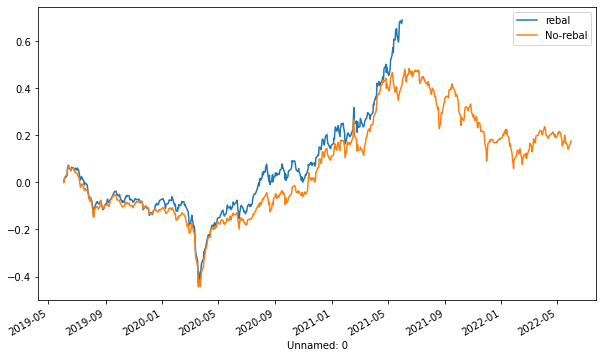

In [82]:
# [코드 5.31] 저PER 전략 리밸러싱 있는 경우와 없는 경우 비교 (Ch5. 백테스트.ipynb)

start_date = '2019-6'
end_date = '2022-5'
initial_money = 100000000

start_year = int(start_date.split('-')[0])
end_year = int(end_date.split('-')[0])

total_df = 0
for temp in range(start_year, end_year):
    this_term_start = str(temp) + '-6'
    this_term_end = str(temp+1) + '-6'
    strategy_date = get_strategy_date(this_term_start)
    low_per = get_value_rank(invest_df, 'PER', strategy_date, 20)


    #low_per = python_quant.get_value_rank(select_code_by_price(price_df, invest_df, this_term_start), 'PER', strategy_date, 20)
    per_backtest = backtest_beta(price_df, low_per, this_term_start, this_term_end, initial_money)
    temp_end = per_backtest[this_term_end].index[0]
    per_backtest = per_backtest[:temp_end]
    initial_money =  per_backtest['종합포트폴리오'][-1]
    if temp == start_year:
        total_df = per_backtest
    else:
        total_df = pd.concat([total_df[:-1], per_backtest])
        
total_df ['일변화율'] = total_df ['종합포트폴리오'].pct_change()
total_df ['총변화율'] = total_df ['종합포트폴리오']/ total_df ['종합포트폴리오'][0] - 1
low_per = get_value_rank(invest_df, 'PER', strategy_date, 20)

#low_per = python_quant.get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PER', get_strategy_date(start_date), 20)
per_backtest = backtest_beta(price_df, low_per, start_date, end_date, initial_money)

plt.figure(figsize=(10, 6))
total_backtest['총변화율'].plot(label='rebal')
per_backtest['총변화율'].plot(label='No-rebal')
plt.legend()
plt.show()

In [150]:
# [코드 5.32] 리밸런싱 백테스트 함수화 (Ch5. 백테스트.ipynb)

def backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, num, value_type=None, value_list=None, date_range=None):
    
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp+1) + '-' + start_date.split('-')[1]
        strategy_date = get_strategy_date(this_term_start)
        
        if strategy.__name__ == 'high_roa':
            #low_per = get_value_rank(invest_df, 'PER', strategy_date, 20)
            st_df = strategy(invest_df, value_type, strategy_date, num)

            #st_df = strategy(select_code_by_price(price_df, fr_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'magic_formula':
            #(fr_df, invest_df, index_date, num)
            st_df = strategy(fr_df, invest_df, strategy_date, num)
            #st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_value_rank':
            #get_value_rank(invest_df, value_type, index_date, num)
            st_df = strategy(invest_df, value_type, strategy_date, num)
            #st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_combo':
            st_df = strategy(value_list, invest_df, strategy_date, num)

            #st_df = strategy(value_list, select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(fs_df, strategy_date, num)

            #st_df = strategy(select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_momentum_rank':
            st_df = strategy(price_df, price_df[this_term_start].index[0] , date_range, num)

            #st_df = strategy(price_df, price_df[this_term_start].index[0] , date_range, num)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(invest_df, fs_df, strategy_date, num)
            #st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), 
                             #select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        
        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money =  backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest])

    total_df ['일변화율'] = total_df ['종합포트폴리오'].pct_change()
    total_df ['총변화율'] = total_df ['종합포트폴리오']/ total_df ['종합포트폴리오'][0] - 1
    
    return total_df

<ipython-input-98-3f4f7cb89d8e>:45: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


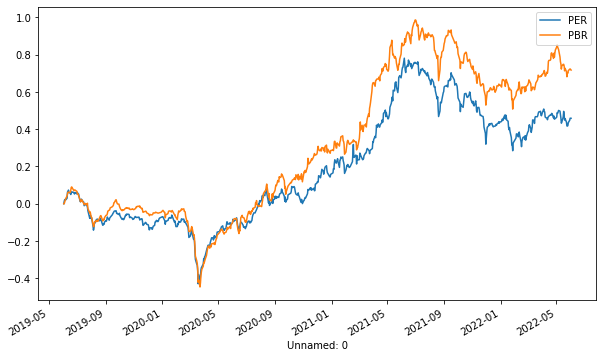

In [105]:
# [코드 5.33] 저PER과 저PBR 비교 (Ch5. 백테스트.ipynb)

start_date = '2019-6'
end_date = '2022-5'
initial_money = 100000000
strategy = get_value_rank

back_test_result1 = backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_type='PER')
back_test_result2 = backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_type='PBR')

plt.figure(figsize=(10, 6))
back_test_result1['총변화율'].plot(label='PER')
back_test_result2['총변화율'].plot(label='PBR')
plt.legend()
plt.show()

<ipython-input-98-3f4f7cb89d8e>:45: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


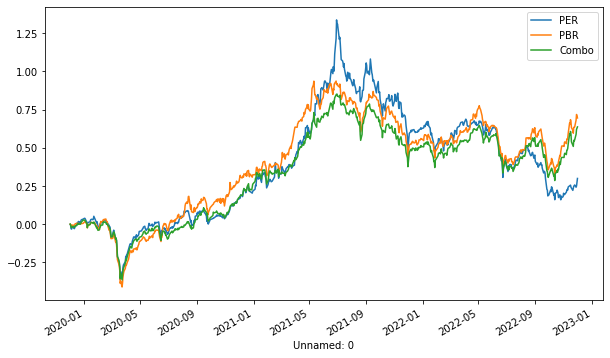

In [115]:
# [코드 5.34] 저PER과 저PBR, 혼합 전략 비교 (Ch5. 백테스트.ipynb)

start_date = '2019-12'
end_date = '2022-5'
initial_money = 100000000
strategy =get_value_rank
strategy2 = make_value_combo

back_test_result1 = backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_type='PER')
back_test_result2 = backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_type='PBR')
back_test_result3 = backtest_re(strategy2, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_list=['PER','PBR','PCR'])

plt.figure(figsize=(10, 6))
back_test_result1['총변화율'].plot(label='PER')
back_test_result2['총변화율'].plot(label='PBR')
back_test_result3['총변화율'].plot(label='Combo')
plt.legend()
plt.show()

In [138]:
start_date = '2019-12'
end_date = '2022-5'

for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp+1) + '-' + start_date.split('-')[1]
        strategy_date = get_strategy_date(this_term_start)
s

'2020/12'

In [172]:
start_date = '2020-6'
end_date = '2022-5'


strategy2 = get_fscore

back_test_result2 = backtest_re(strategy2, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20)


<ipython-input-7-fab60ce7932b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
<ipython-input-7-fab60ce7932b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
<ipython-input-7-fab60ce7932b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

<ipython-input-150-9a4f67056f7a>:45: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]
<ipython-input-7-fab60ce7932b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
<ipython-input-7-fab60ce7932b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df[

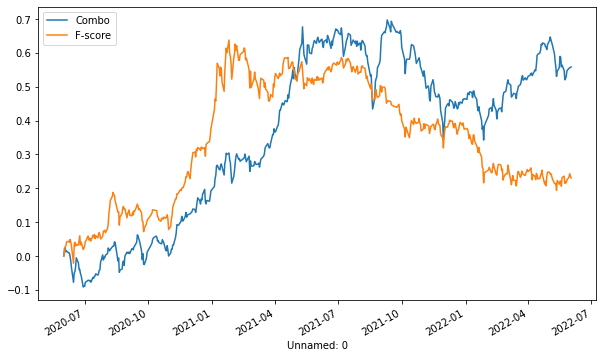

In [173]:
# [코드 5.35] F-score와 혼합 전략 비교 (Ch5. 백테스트.ipynb)

start_date = '2020-6'
end_date = '2022-5'
#strategy_date='2019/12'
initial_money = 100000000
strategy1 = make_value_combo
strategy2 = get_fscore

back_test_result1 = backtest_re(strategy1, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_list=['PER','PBR'])
back_test_result2 = backtest_re(strategy2, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20)

plt.figure(figsize=(10, 6))
back_test_result1['총변화율'].plot(label='Combo')
back_test_result2['총변화율'].plot(label='F-score')
plt.legend()
plt.show()

<ipython-input-150-9a4f67056f7a>:45: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]
<ipython-input-7-fab60ce7932b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
<ipython-input-7-fab60ce7932b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df[

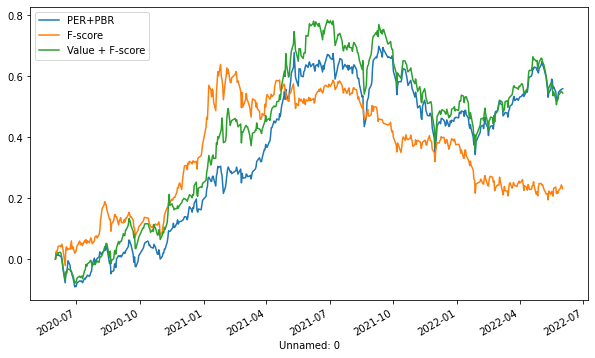

In [193]:
# [코드 5.36] F-score, PBR+PER, F-score+PBR+PER 전략 비교 (Ch5. 백테스트.ipynb)

start_date = '2020-6'
end_date = '2022-6'
initial_money = 100000000
strategy1 = make_value_combo
strategy2 = get_fscore
strategy3 = get_value_quality

back_test_result1 = backtest_re(strategy1, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_list=['PER','PBR'])
back_test_result2 = backtest_re(strategy2, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20)
back_test_result3 = backtest_re(strategy3, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20)

plt.figure(figsize=(10, 6))
back_test_result1['총변화율'].plot(label='PER+PBR')
back_test_result2['총변화율'].plot(label='F-score')
back_test_result3['총변화율'].plot(label='Value + F-score')
plt.legend()
plt.show()

In [205]:
# [코드 5.37] CAGR 계산 (Ch5. 백테스트.ipynb)

start_date = '2020-6'
end_date = '2022-5'
initial_money = 100000000
strategy = get_value_rank
strategy3 = get_value_quality

back_test_result3 = backtest_re(strategy3, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20)

#back_test_result = backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_type='PER')

num_of_year = int(end_date.split('-')[0]) - int(start_date.split('-')[0])
CAGR = (back_test_result3.iloc[-1]['종합포트폴리오'] / back_test_result3.iloc[0]['종합포트폴리오']) ** (1/num_of_year) - 1
CAGR

<ipython-input-7-fab60ce7932b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
<ipython-input-7-fab60ce7932b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
<ipython-input-7-fab60ce7932b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

0.24264320703893127

In [162]:
# [코드 5.38] MDD 계산 (Ch5. 백테스트.ipynb)

max_list = [0]
mdd_list = [0]

for i in back_test_result.index[1:]:
    max_list.append(back_test_result['총변화율'][:i].max())
    if max_list[-1] > max_list[-2]:
        mdd_list.append(0)
    else:
        mdd_list.append(min(back_test_result['총변화율'][i] - max_list[-1], mdd_list[-1])   )
        
back_test_result['max'] = max_list
back_test_result['MDD'] = mdd_list

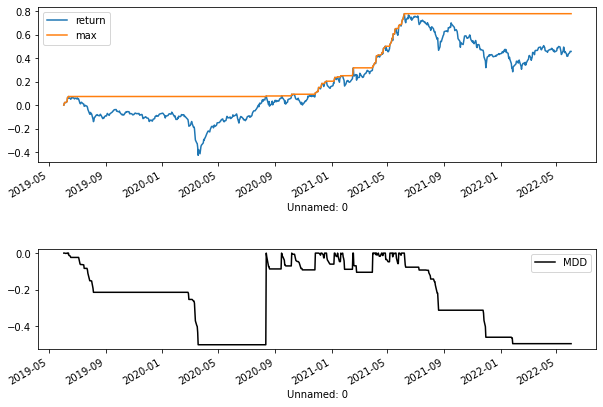

In [163]:
# [코드 5.39] MDD 그래프 그리기 (Ch5. 백테스트.ipynb)

plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
back_test_result['총변화율'].plot(label='return')
back_test_result['max'].plot(label='max')
plt.legend()

plt.subplot(3,1,3)
back_test_result['MDD'].plot(label='MDD', c='black')
plt.legend()

In [164]:
# [코드 5.40] MDD 함수화 (Ch5. 백테스트.ipynb)

def get_mdd(back_test_df):
    max_list = [0]
    mdd_list = [0]

    for i in back_test_df.index[1:]:
        max_list.append(back_test_df['총변화율'][:i].max())
        if max_list[-1] > max_list[-2]:
            mdd_list.append(0)
        else:
            mdd_list.append(min(back_test_df['총변화율'][i] - max_list[-1], mdd_list[-1])   )

    back_test_df['max'] = max_list
    back_test_df['MDD'] = mdd_list
    
    return back_test_df

<ipython-input-150-9a4f67056f7a>:45: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  temp_end = backtest[this_term_end].index[0]


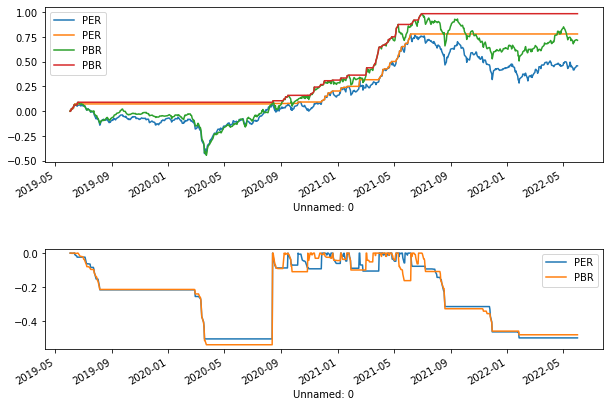

In [174]:
# [코드 5.41] MDD 비교하기 (Ch5. 백테스트.ipynb)

start_date = '2019-6'
end_date = '2022-5'
initial_money = 100000000
strategy = get_value_rank

back_test_result1 = backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_type='PER')
back_test_result2 = backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, 20, value_type='PBR')

back_test_result1 = get_mdd(back_test_result1)
back_test_result2 = get_mdd(back_test_result2)


plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
back_test_result1['총변화율'].plot(label='PER')
back_test_result1['max'].plot(label='PER')
back_test_result2['총변화율'].plot(label='PBR')
back_test_result2['max'].plot(label='PBR')
plt.legend()

plt.subplot(3,1,3)
back_test_result1['MDD'].plot(label='PER')
back_test_result2['MDD'].plot(label='PBR')
plt.legend()

In [176]:
back_test_result1

,주식포트폴리오,현금포트폴리오,종합포트폴리오,일변화율,총변화율,max,MDD
Unnamed: 0,,,,,,,
2019-06-03,99764030.0,235970.0,100000000.0,NaN,0.000000,0.000000,0.000000
2019-06-04,101194817.0,235970.0,101430787.0,0.014308,0.014308,0.014308,0.000000
2019-06-05,102008603.0,235970.0,102244573.0,0.008023,0.022446,0.022446,0.000000
2019-06-07,101836801.0,235970.0,102072771.0,-0.001680,0.020728,0.022446,-0.001718
2019-06-10,102730874.0,235970.0,102966844.0,0.008759,0.029668,0.029668,0.000000
...,...,...,...,...,...,...,...
2022-05-26,141773400.0,155651.0,141929051.0,0.001897,0.419291,0.780872,-0.496452
2022-05-27,143359920.0,155651.0,143515571.0,0.011178,0.435156,0.780872,-0.496452
2022-05-30,144637870.0,155651.0,144793521.0,0.008905,0.447935,0.780872,-0.496452


In [179]:
!pip install -U finance-datareader


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [180]:
# 라이브러리
import numpy as np
import pandas as pd
import pprint
from itertools import groupby, chain
import FinanceDataReader as fdr
from scipy.stats import norm

In [181]:
# 무위험 금리(CD91) 불러오기

def get_product(KEY, STAT_CD, PERIOD, START_DATE, END_DATE):
    # 파이썬에서 인터넷을 연결하기 위해 urllib 패키지 사용. urlopen함수는 지정한 url과 소켓 통신을 할 수 있도록 자동 연결해줌
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    from lxml import html
    from urllib.request import Request, urlopen
    from urllib.parse import urlencode, quote_plus, unquote
    import pprint

    url = 'http://ecos.bok.or.kr/api/StatisticSearch/{}/xml/kr/1/30000/{}/{}/{}/{}/{}' \
            .format(KEY # 인증키
                   , STAT_CD # 추출할 통계지표의 코드
                   , PERIOD # 기간 단위
                   , START_DATE # 데이터 시작일
                   , END_DATE # 데이터 종료일
                   , ITEM_CODE )# 통계항목 코드

    response = requests.get(url).content.decode('utf-8')
    
    xml_obj = BeautifulSoup(response, 'lxml-xml')
    # xml_obj
    rows = xml_obj.findAll("row")
    return rows

# 파라미터 정의
# 추출하고자 하는 통계지표 disc type - {통계지표 코드: 통계지표명}
data_dict = {
'817Y002' : '시장금리(일별)'
}

# 인증키
KEY = 'DSFS58V3CLRQ4KOKWNVH'

# 통계항목 코드
ITEM_CODE = '010502000'

# 그외 파라미터
PERIOD = 'D'
START_DATE = '20120101'
END_DATE = '20230119'

# API의 반환(출력)값 중 저장하고자 하는 항목(item) 리스트
item_list = [
'STAT_CODE' # 통계표코드
, 'STAT_NAME' # 통계명
, 'ITEM_CODE1' # 통계항목1코드
, 'ITEM_NAME1' # 통계항목명1
, 'ITEM_CODE2' # 통계항목2코드
, 'ITEM_NAME2' # 통계항목명2
, 'ITEM_CODE3' # 통계항목3코드
, 'ITEM_NAME3' # 통계항목명3
, 'UNIT_NAME' # 단위
, 'TIME' # 시점
, 'DATA_VALUE'# 값
]

# 결과치를 담을 빈 리스트 생성
result_list = list()

# API를 순차적으로 호출하고 값을 담는 for loop 구문
for k in data_dict.keys():
    rows = get_product(KEY, k, PERIOD, START_DATE, END_DATE)
    print(len(rows)) # 수집해야 할 데이터의 row가 총 몇 개인지 출력
    
    for p in range(0, len(rows)):
        info_list = list()
        
        for i in item_list:
            try:
                individual_info = rows[p].find(i).text # 만약 반환 중 error가 발생하면
            except:
                individual_info = "" # 해당 항목은 공란으로 채운다
        
            info_list.append(individual_info)
        result_list.append(info_list)
    result_list
    
import pandas as pd
from pandas import DataFrame
from datetime import datetime

# 결과 리스트를 DataFrame으로 변환 + 컬럼명 지정
result_df = DataFrame(result_list, columns=[
'통계표코드'
, '통계명'
, '통계항목1코드'
, '통계항목명1'
, '통계항목2코드'
, '통계항목명2'
, '통계항목3코드'
, '통계항목명3'
, '단위'
, '시점'
, '값'
]).drop_duplicates() # 중복된 row 제거

result_df

2734


,통계표코드,통계명,통계항목1코드,통계항목명1,통계항목2코드,통계항목명2,통계항목3코드,통계항목명3,단위,시점,값
0,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20120102,3.56
1,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20120103,3.56
2,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20120104,3.56
3,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20120105,3.56
4,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20120106,3.56
...,...,...,...,...,...,...,...,...,...,...,...
2729,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20230113,3.88
2730,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20230116,3.79
2731,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20230117,3.74
2732,817Y002,1.3.2.1. 시장금리(일별),010502000,CD(91일),,,,,연%,20230118,3.7


In [183]:
numeric_df = pd.to_numeric(result_df['값'])
r_f = numeric_df.mean()
r_f = (r_f / 100) / 255
r_f

7.472510291607498e-05

In [184]:
# 클래스 선언
class Core():
    def __init__(self):
        self.annual=252
    # 산술평균 수익률
    def average(self, returns):
        return returns.mean()*self.annual
    # 기하평균 수익률
    def cagr(self, returns):
        return (1+returns).prod() ** (self.annual/len(returns))-1
    # 표준편차
    def stdev(self, returns):
        return returns.std() * np.sqrt(self.annual)
    # 하방 표준편차
    def downdev(self, returns, target=0.0):
        returns = returns.copy()
        returns.loc[returns>target]=0
        summation = (returns ** 2).sum()
        return np.sqrt(self.annual * summation / len(returns))
    # 상방 표준편차
    def updev(self, returns, target=0.0):
        returns = returns.copy()
        returns.loc[returns < target] = 0
        summation = (returns ** 2).sum()
        return np.sqrt(self.annual * summation / len(returns))
    # 공분산
    def covar(self, returns, benchmark):
        return returns.cov(benchmark) * self.annual
    # 상관계수
    def correl(self, returns, benchmark):
        return returns.corr(benchmark)
    # 베타
    def beta(self, returns, benchmark):
        return returns.cov(benchmark) / returns.std() ** 2
    # 알파 : R펀드실제 －[R무위험 ＋ β펀드 {E(R시장) －R무위험 }]
    def alpha(self, returns, benchmark):
        return (1+returns).prod() - (r_f + (returns.cov(benchmark)/returns.std() ** 2)) * (benchmark.mean() - r_f)
        
    # 한번에 출력
    def print_result(self, returns, benchmark, target=0.0):
        average = self.average(returns)
        cagr = self.cagr(returns)
        stdev = self.stdev(returns)
        downdev = self.downdev(returns, target)
        updev = self.updev(returns, target)
        covar = self.covar(returns, benchmark)
        correl = self.correl(returns, benchmark)
        beta = self.beta(returns, benchmark)
        alpha = self.alpha(returns, benchmark)
        result = {"산술평균" : average,
              "CAGR": cagr,
              "표준편차": stdev,
              "하방 표준편차": downdev,
              "상방 표준편차": updev,
              "공분산": covar,
              "상관계수": correl,
                 "베타": beta,
                 "알파" : alpha}
        return result

In [194]:
# 데이터 가져오기
if __name__ == "__main__":
    
    start_date = '2012-01-01'
    end_date = '2023-01-19'
    #pf_return=back_test_result3['일변화율'].dropna()

    #samsung = fdr.DataReader('005930', start_date, end_date)
    kospi = fdr.DataReader('KS11', start_date, end_date)
    #back_test_result3['일변화율']
    pf_return=back_test_result3['일변화율'].dropna()

    #samsung_ret = samsung['Close'].pct_change().dropna()
    kospi_ret = kospi['Close'].pct_change().dropna()
    
    core=Core()
    core_result = core.print_result(pf_return, kospi_ret)
    
    pprint.pprint(core_result)

{'CAGR': 0.24700492011997777,
 '공분산': 0.02554905630372389,
 '베타': 0.5475483522120704,
 '산술평균': 0.24417134403312032,
 '상관계수': 0.6617859410834345,
 '상방 표준편차': 0.15567013769537852,
 '알파': 1.5441232022392697,
 '표준편차': 0.21601116219152044,
 '하방 표준편차': 0.15023362498715567}


In [187]:
# 클래스 선언
class Tail():
    def __init__(self):
        self.annual=252
    # 왜도 : 수익률 분포의 비대칭 정도를 측정하기 위한 지표 
    def skewness(self, returns):
        return returns.skew()
    # 첨도 : 수익률 분포의 팻테일 정도를 측정하기 위한 지표
    def kurtosis(self, returns):
        return returns.kurtosis()
    # 공왜도 : 벤치마크 대비 전략의 수익률 분포가 얼마나 왜도를 가지고 있는지 알고 싶을 떄 사용하는 지표
    def coskewness(self, returns, benchmark):
        r_mean = returns.mean()
        b_mean = benchmark.mean()
        r_stdev = returns.std()
        b_stdev = benchmark.std()
        T = len(returns)        
        summation = ((returns - r_mean) * ((benchmark - b_mean) ** 2) / (r_stdev * (b_stdev ** 2))).sum()
        return (T / ((T - 1) * (T - 2))) * summation
    # 공첨도 : 공첨도는 어떤 두 수익률 데이터가 있을 때 벤치마크 대비 전략 수익률의 상대적인 첨도를 측정하기 위한 지표
    def cokurtosis(self, returns, benchmark):
        r_mean = returns.mean()
        b_mean = benchmark.mean()
        r_stdev = returns.std()
        b_stdev = benchmark.std()
        T = len(returns)
        summation = ((returns - r_mean) * ((benchmark - b_mean) ** 3) / (r_stdev * (b_stdev ** 3))).sum()
        return ((T * (T + 1)) / ((T - 1) * (T - 2) * (T - 3))) * summation - (3 * (T - 1) ** 2) / ((T - 2) * (T - 3))
    # 낙폭 : 현재 가격이 전 고점과 비교했을 때 얼마만큼의 손실을 보이고 있는지 나타내는 지표
    def drawdown(self, returns):
        cumulative = (1 + returns).cumprod()
        highwatermark = cumulative.cummax()
        drawdown = (cumulative / highwatermark) - 1
        return drawdown
    # 최대낙폭 : 백테스팅 기간 중 가장 큰 낙폭을 측정하기 위한 지표
    def maximum_drawdown(self, returns):
        return np.min(self.drawdown(returns))
    # 낙폭기간 : 과거 낙폭을 경험했던 여러 구간들에서 전 고점을 회복하기 전까지 낙폭이 유지된 기간
    def drawdown_duration(self, returns):
        drawdown = self.drawdown(returns)
        ddur = list(chain.from_iterable((np.arange(len(list(j))) + 1).tolist() if i==1 else [0] * len(list(j)) for i, j in groupby(drawdown != 0)))
        ddur = pd.DataFrame(ddur)
        ddur.index = returns.index
        return ddur
    # 최장낙폭기간 : 낙폭기간 중 가장 긴 기간을 알려주는 지표
    def maximum_drawdown_duration(self, returns):
        return self.drawdown_duration(returns).max()[0]
    # 역사적 VaR : 과거부터 수익률을 나열했을 때 하위 5% 지점에 있는 수익률
    def hVaR(self, returns, percentile=99):
        return returns.quantile(1 - percentile / 100)
    # 분석적 VaR : 정상적인 시장 상황 하에서 발생할 수 있는 최대 예상손실액
    def aVaR(self, returns, percentile=99):
        r_stdev = returns.std() 
        z_score = norm.ppf(percentile/100)
        return -z_score * r_stdev 
#     * np.sqrt(self.annual) # 연이율 기준
    # CVaR : VaR를 초과하는 손실률들의 평균값
    def CVaR(self, returns, percentile=99):
        return returns[returns < self.hVaR(returns, percentile)].mean()
    # 한번에 출력
    def print_result(self, returns, benchmark, percentile=99):
        skew = self.skewness(returns)
        kurt = self.kurtosis(returns)
        coskew = self.coskewness(returns, benchmark)
        cokurt = self.cokurtosis(returns, benchmark)
        mdd = self.maximum_drawdown(returns)
        mddur = self.maximum_drawdown_duration(returns)
        hvar = self.hVaR(returns, percentile)
        avar = self.aVaR(returns)
        cvar = self.CVaR(returns, percentile)
        
        result = {"Skewness" : skew,
                  "Kurtosis" : kurt,
                  "Co-Skewness" : coskew,
                  "Co-Kurtosis" : cokurt,
                  "Maximum Drawdown" : mdd,
                  "Maximum Drawdown Duration" : mddur,
                  "99% HVaR" : hvar,
                  "99% AVaR" : avar,
                  "99% CVaR" : cvar}
        
        return result

In [195]:
if __name__ == "__main__":
    
    start_date = '2018-12-01'
    end_date = '2023-01-19'
    
    # samsung = '005930'
    kospi = 'KS11'
    
    #samsung = fdr.DataReader(samsung, start_date, end_date)
    kr = fdr.DataReader(kospi, start_date, end_date)
    
    # samsung_ret = samsung['Close'].pct_change().dropna()
    # kospi_ret = kr['Close'].pct_change().dropna()
    pf_return=back_test_result3['일변화율'].dropna()


    # Tail-Risk Analytics
    tail = Tail()
    tail_result = tail.print_result(pf_return, kospi_ret)
    
    pprint.pprint(tail_result)
    

{'99% AVaR': -0.03165560231302397,
 '99% CVaR': -0.0425405129471,
 '99% HVaR': -0.0393692532038908,
 'Co-Kurtosis': 1.3123590899468112,
 'Co-Skewness': -0.2868040725153314,
 'Kurtosis': 1.1802881652906572,
 'Maximum Drawdown': -0.23946769316102312,
 'Maximum Drawdown Duration': 229,
 'Skewness': -0.2918046025686256}


In [189]:
# 클래스 선언
class Performance(Core, Tail):    # Inherit from Core(), Tail()  
    #추적 오차
    def track_error(self, returns, benchmark):
        return self.stdev(returns - benchmark)
    # 정보 비율 : 
    def information_ratio(self, returns, benchmark):
        return self.average(returns - benchmark) / self.stdev(returns - benchmark)
    # 샤프 비율 : 전략의 성과를 평가하기 위한 지표로 초과 수익률의 평균을 변동성으로 나눔
    def sharpe_ratio(self, returns):
        return self.average(returns - r_f) / self.stdev(returns)
    # 조정 샤프 비율 : 초과 수익률의 왜도와 첨도를 반영하여 테일 리스크가 반영된 샤프비율
    def adjusted_sharpe_ratio(self, returns):
        skewness = self.skewness(returns)
        kurtosis = self.kurtosis(returns)
        sharpe_ratio = self.sharpe_ratio(returns)
        return sharpe_ratio * (1 + skewness * sharpe_ratio / 6 - kurtosis * (sharpe_ratio ** 2) / 24)
    # 소르티노 비율 : 분모에 표준편차가 아닌 하방 표준편차를 적용한 성과 지표
    def sortino_ratio(self, returns, benchmark, target=0.0):
        return self.average(returns - benchmark) / self.downdev(returns, target)
    # 칼마 비율 : 최대낙폭 대비 전략의 초과수익률을 측정하는 지표
    def calmar_ratio(self, returns, benchmark):
        return -self.average(returns - benchmark) / self.maximum_drawdown(returns)
    # 트레이너 비율 : 위험 한 단위를 받고 얻은 초과성과가 얼마인지를 측정하는 성과지표
    def treynor_ratio(self, returns, benchmark):
        return self.average(returns - benchmark) / self.beta(returns, benchmark)
    # VaR 대비 성과 비율 : 위험 지표 중 하나인 VaR 대비 수익의 비율을 나타내는 지표
    def reward_to_VaR_ratio(self, returns, benchmark):
        return -self.average(returns - benchmark) / self.hVaR(returns)
    # CVaR 대비 성과 비율 : VaR 대신 분모에 CVaR를 사용한 지표
    def reward_to_CVaR_ratio(self, returns, benchmark):
        return -self.average(returns - benchmark) / self.CVaR(returns)
    # 승률 : 전체 매매 횟수 중 수익을 얻은 거래의 비율
    def hit_ratio(self, returns):
        return len(returns[returns > 0]) / (len(returns[returns > 0]) + len(returns[returns < 0]))
    # 손익비 : 전략을 운용할 때 1회당 평균 손실 금액 대비 1회당 평균 이익 금액의 비율
    def gain_to_pain_ratio(self, returns):
        return - returns[returns > 0].sum() / returns[returns < 0].sum()
    # 한번에 출력
    def print_result(self, returns, benchmark, target=0.0):
        track_error = self.track_error(returns, benchmark)
        information_ratio = self.information_ratio(returns, benchmark)
        sr = self.sharpe_ratio(returns)
        asr = self.adjusted_sharpe_ratio(returns)
        sortino = self.sortino_ratio(returns, benchmark, target)
        calmar = self.calmar_ratio(returns, benchmark)
        treynor = self.treynor_ratio(returns, benchmark)
        varratio = self.reward_to_VaR_ratio(returns, benchmark)
        cvarratio = self.reward_to_CVaR_ratio(returns, benchmark)
        hitratio = self.hit_ratio(returns)
        gpratio = self.gain_to_pain_ratio(returns)
        
        result = {"Track Error" : track_error,
                  "Information Ratio" : information_ratio,
                  "Sharpe Ratio" : sr,
                  "Adjusted Sharpe Ratio" : asr,
                  "Sortino Ratio" : sortino,
                  "Calmar Ratio" : calmar,
                  "Treynor Ratio" : treynor,
                  "Reward-to-VaR Ratio" : varratio,
                  "Reward-to-CVaR Ratio" : cvarratio,
                  "Hit Ratio" : hitratio,
                  "Gain-to-Pain Ratio" : gpratio}
    
        return result

In [199]:
if __name__ == "__main__":
    
    start_date = '2018-12-01'
    end_date = '2023-01-19'
    
    #samsung = '005930'
    kospi = 'KS11'
    
    #samsung = fdr.DataReader(samsung, start_date, end_date)
    kr = fdr.DataReader(kospi, start_date, end_date)
    
    # samsung_ret = samsung['Close'].pct_change().dropna()
    # kospi_ret = kr['Close'].pct_change().dropna()
    
    # samsung['Null Ret'] = 0.0
    # null_ret = samsung['Null Ret']
    pf_return=back_test_result3['일변화율'].dropna()

    # Performance Evaluation Analytics
    perform = Performance()
    perform_result = perform.print_result(pf_return, kospi_ret)
    
    pprint.pprint(perform_result)

{'Adjusted Sharpe Ratio': 0.9344340124021643,
 'Calmar Ratio': 0.4666271258015919,
 'Gain-to-Pain Ratio': 1.2112946618477232,
 'Hit Ratio': 0.5443548387096774,
 'Information Ratio': 0.6739834743573492,
 'Reward-to-CVaR Ratio': 2.6267224732578884,
 'Reward-to-VaR Ratio': 2.8383093985390215,
 'Sharpe Ratio': 1.0431896935885057,
 'Sortino Ratio': 0.7437890245384094,
 'Track Error': 0.16579356265168535,
 'Treynor Ratio': 0.20407717588891036}


In [200]:
    # 1. Core Analytics
    core = Core()
    core_result = core.print_result(pf_return, kospi_ret)
    
    # 2. Tail-Risk Analytics
    tail = Tail()
    tail_result = tail.print_result(pf_return, kospi_ret)
    
    # 3. Performance Evaluation Analytics
    perform = Performance()
    perform_result = perform.print_result(pf_return, kospi_ret)
        
    table = {**core_result, **tail_result, **perform_result}
    
    result = pd.Series(table)
    result = result.to_frame()
    result

,0
산술평균,0.244171
CAGR,0.247005
표준편차,0.216011
하방 표준편차,0.150234
상방 표준편차,0.155670
공분산,0.025549
상관계수,0.661786
베타,0.547548
알파,1.544123
Skewness,-0.291805
